In [ ]:
# Set up the libraries

!pip install scikit-learn==1.2.2
!pip install numpy
!pip install pandas
!pip install matplotlib

In [ ]:
# Ignore this part. This is a sample simulation to test the GP library.

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.metrics.pairwise import rbf_kernel
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
gpr.score(X, y)
gpr.predict(X[:2,:], return_std=True)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))

In [ ]:
import numpy as np
A = rbf_kernel([[1],[1]],[[2]])
print(A)
print(np.log(10))

NameError: ignored

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import process_time
from itertools import combinations

# The Class MSD is the main problem and contains all necessary parameters

import numpy as np
import matplotlib.pyplot as plt


from pandas.io.formats.style_render import non_reducing_slice
class MSD:
  def __init__(self, Wind_model, graph=None, pois=set(), z=0, V_start='a', V_end='a', t_start=0, t_end = 1, norm = 400):
    self.graph = graph
    self.pois = pois
    self.V_start = V_start
    self.V_end = V_end
    self.t_end = t_end
    self.t_start = t_start
    self.norm = 1
    self.z = z

    self.dynamic_model = Wind_model

  def MI_distance(self, S):
    total_reward = 0

    for s in S:
      reward = 0
      (x,y) = self.graph.get_pos(s)
      (x,y,z) = self.dynamic_model.step(self.t_start, self.t_end, x, y, self.z)
      for poi in self.pois:
        reward += self.distance(poi[0], poi[1], x, y)

      total_reward += 1/reward

    return total_reward

  # A function to compute Mutual Information
  def Prediction(self, S, kernel, y, measurement, noise_coviance=900):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = np.array(y)


    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    return mean, variance, S_pos

  def error(self, S, kernel, measurement, noise_coviance=900):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm+0.001])
    POI_pos = np.array(POI_pos)


    #variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    #,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    error =0

    for i in range(POI_pos.shape[0]):

      pos = POI_pos[i]
      value = measurement(pos[0]/self.norm, pos[1]/self.norm)

      error += (value-mean[i])**2

    return error**0.5

  # A function to compute Mutual Information
  def MI(self, S, kernel):

    D = len(self.pois)

    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)


  # A function to compute Mutual Information
  def MI_stochastic(self, S, kernel, W=(49.8**2), noise_coviance=900):

    D = len(self.pois)

    # Convert the sensor set to position array
    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    # Convert the PoIs set to position array
    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    # Appoximation
    Kernel_A = kernel(POI_pos, S_pos)
    Kernel_B = kernel(S_pos, S_pos)

    for i in range(len(POI_pos)):
      for j in range(len(S)):
        x_diff = (POI_pos[i] - S_pos[j])
        numerator  = 1/(W+  noise_coviance)
        determinator = 1+ ( 1/W * noise_coviance)

        Kernel_A[i,j] = np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    for i in range(len(S)):
      for j in range(len(S)):
        if not i == j:
          x_diff = (S_pos[i] - S_pos[j])
          numerator  = 1/(W+  2*noise_coviance)
          determinator = 1+ ( 1/W * 2*noise_coviance)

          Kernel_B[i,j] =  np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    Kernel_C = Kernel_A.transpose()

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul( Kernel_A
    ,np.linalg.inv(Kernel_B)) , Kernel_C)



    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)

  # Different solvers to solve the main problem
  def planner(self, n_agents, budget, n_sensor, method="D", kernal=50):
    if method == "D":

      return self.SGA(budget, n_sensor, n_agents, kernal)

    if method == "S":
      pass


    path = [("V0",0)]
    return path


  # Computer the cost
  def cost(self, S):
    edge_list = self.TSP_solver(S)

    total_cost = 0
    for edge in edge_list:
      x1,y1 = self.graph.get_pos(edge[0])
      x2,y2 = self.graph.get_pos(edge[1])
      total_cost += self.distance(x1,y1,x2,y2)
    return total_cost

  def TSP_solver(self, S):
    Gp = nx.Graph()
    for i in S:
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(Gp, weight="weight")
    edge_list = list(nx.utils.pairwise(cycle))

    return edge_list

  def distance(self, x1, y1, x2, y2):
    return sqrt((x1-x2)**2 + (y1-y2)**2)


  def SGA(self, budget, n_sensor, n_agents, kernal = 0):
    A = set()
    P = []
    for i in range(n_agents):
      P.append(self.GCB(A, budget, n_sensor, kernal))
      A.update(P[-1])

    return P

  def GCB(self, A, budget, n_sensor, kernal = 0):
    S = set([self.V_start])
    V_prime = set(self.graph.get_nodes())

    V_prime = V_prime - A
    V_prime = V_prime - S

    while len(V_prime) and n_sensor > 0:
      max_reward = -float('inf')
      max_node = None

      for i in V_prime:
        G = S.copy()
        G.add(i)

        #print(self.MI_stochastic(G, kernal), self.MI(G, kernal))
        reward = self.MI_stochastic(G, kernal) - self.MI_stochastic(S, kernal)
        #print(G, self.MI(G, kernal))
        if len(S) == 1:
          cost1 =  self.cost(G) + 500
        else:
          cost1 =  self.cost(G) - self.cost(S) + 500


        if reward/cost1 > max_reward:
          max_reward = reward/cost1
          max_node = i

      G = S.copy()
      G.add(max_node)

      #print(G)
      if  self.cost(G) <= budget:
        S.add(max_node)
        n_sensor -= 1

      V_prime = V_prime - (set([max_node]))
    return S

  def brute_force(self, n_agents, budget, n_sensor, method="D", kernal=0):
    P = []
    max_reward = -float('inf')
    P_prime = [set(self.V_start)]


    for i in range(n_agents):
      temp = []
      for j in P_prime:
        V_prime = set(self.graph.get_nodes()) - j
        for k in [com for com in combinations(V_prime, n_sensor)]:
          k = set(k)
          k.add(self.V_start)
          if self.cost(k) <= budget:
            temp.append(k)
      P_prime = temp

    for j in P_prime:
      reward = self.MI(j, kernal)
      if  reward > max_reward:
        P = j
        max_reward = max_reward

    return P

  def visualize(self, S):
    fig, ax = plt.subplots()
    Gp = nx.Graph()

    for i in G.get_nodes():
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    colors = [ "red", "orange", "purple", "yellow"]
    for S_S, color in zip(S,colors):
      edge_list = self.TSP_solver(S_S)
      #print(edge_list)

      for edge in edge_list:
        point_a = G.get_pos(edge[0])
        point_b = G.get_pos(edge[1])
        ax.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], color=color)
        if not edge[1] == self.V_start:
          ax.plot(point_b[0], point_b[1], "*r")
          point_b = self.dynamic_model.step(self.t_start, self.t_end, point_b[0], point_b[1], self.z)
          ax.plot(point_b[0], point_b[1], "bo")

      for PoI in self.pois:
        ax.plot(PoI[0],PoI[1],"kD")
      '''
      # Draw the route
      nx.draw_networkx(
          Gp,
          pos,
          with_labels=True,
          edgelist=edge_list,
          edge_color="red",
          node_size=200,
          width=3,
      )
      '''
    return ax


In [ ]:
# The Class graph create the graph network for the vis

import networkx as nx

class graph:
  def __init__(self,gdict=None):
      self.gdict = {}    # A dict of (node1, node2)
      self.edict = {}   # A dict of ((node1, node2), edge)
      self.ndict = {}   # A dict of (node, position)

  # Add the new node
  def AddNode(self, nodes, values):
    if not (node in self.ndict):
      self.ndict[node] = value

  # Add the new edge
  def AddEdge(self, edge, cost):
    edge = set(edge)
    (vrtx1, vrtx2) = tuple(edge)
    if vrtx1 in self.gdict:
      self.gdict[vrtx1].append(vrtx2)
    else:
      self.gdict[vrtx1] = [vrtx2]

    if vrtx2 in self.gdict:
      self.gdict[vrtx2].append(vrtx1)
    else:
      self.gdict[vrtx2] = [vrtx1]


    self.edict[(vrtx1, vrtx2)] = cost
    self.edict[(vrtx2, vrtx1)] = cost

  # List the edge names
  def edges(self):
    edgename = []
    for vrtx in self.gdict:
      for nxtvrtx in self.gdict[vrtx]:
        if {nxtvrtx, vrtx} not in edgename:
          edgename.append({vrtx, nxtvrtx})
    return edgename

  # List all nodes
  def get_nodes(self):
      return self.gdict.keys()

  # Display the graph as a List
  def get_gdict(self):
      return self.gdict

  # Get the cost from node1 to node2
  def get_cost(self, vrtx1, vrtx2):
    return self.edict[(vrtx1, vrtx2)]

  # Get all edges at the node
  def get_edges(self, vrtx):
    if vrtx in self.gdict:
      return self.gdict[vrtx]
    return []

  # the the position of the node
  def get_pos(self, vrtx):
    if vrtx in self.ndict:
      return self.ndict[vrtx]
    return []
  '''
  def visualize(self):
    G = nx.Graph()

    for vrtx in self.gdict:
      for vrtx2 in self.gdict[vrtx]:
        G.add_edges_from((vrtx, vrtx2))

    #pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos=self.ndict)
    nx.draw_networkx_labels(G, pos=self.ndict)
    #nx.draw_networkx_edges(G, pos, edge_color = 'tab:red')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = get_edge_labels(G))
    #nx.draw_networkx_edge_labels(G,pos)

    plt.show()
  '''

In [ ]:
from pandas.core.groupby.groupby import T
# The Class Wind_model models the DYNAMICS OF AIRDROP
class Wind_model:
  def __init__(self, W_x, W_y, m_c, rho, kappa,  T=1, g=9.8):

    self.W_x = W_x
    self.W_y = W_y

    self.m_c = m_c
    self.rho = rho
    self.kappa = kappa

    self.T = T
    self.g = g


  # Compute the 3-d position at t_end
  def step(self, t, t_end, x_0, y_0, z_0, uncetain=(0,0)):
    x = x_0
    y = y_0
    z = z_0
    z_dot = 0

    while t <= t_end and z >= 0:
      #print(t,x,y,z)
      x = x + self.W_x(x,y,z) * self.T
      y = y + self.W_y(x,y,z) * self.T

      extra_force = self.g - 1/(0.5*self.m_c)* self.rho * self.kappa * (z_dot**2)
      z = z + z_dot * self.T - 0.5* extra_force * (self.T**2)
      z_dot = z_dot - extra_force *self.T

      t = t + self.T

    if uncetain == (0,0):
      return x,y,z
    mean, std = uncetain
    x = x + np.random.normal(mean, std)
    y = y + np.random.normal(mean, std)
    return x,y,z


  # Visualize the possible drop points
  def plot(self, x_low, y_low, x_high, y_high, z, samples):

    x = np.linspace(x_low, x_high, samples)
    y = np.linspace(y_low, y_high, samples)
    X,Y = np.meshgrid(x,y)
    U = W_x(X,Y,z)
    V = W_y(X,Y,z)


    return X,Y,U,V


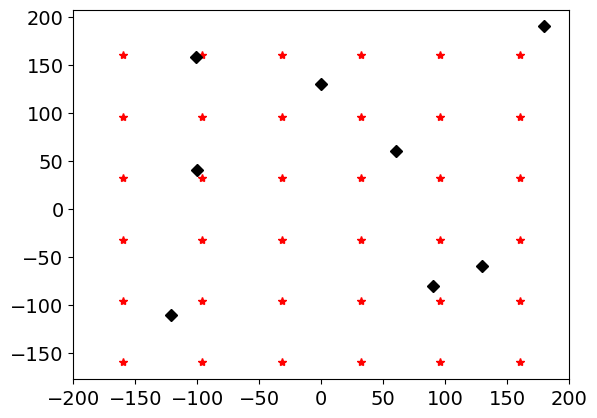

In [ ]:
# Create Graph and PoIs. Also, visualize the graph.
plt.rcParams.update({'font.size': 14})
G = graph()
Nodes = ["V"+str(i) for i in range(0,36)]
#values = [(0,0), (0,13), (31,13), (82, 16), (180, 170), (150,110),(-100,-20),(50,-90),(90,-120),(160,-85),(-160,-5),(-80,-70),(71,120),(-66,-110),(-9,135),(90,-70)]
#edges = [("V0","V1",2), ("V0","V2",4), ("V0","V7",5), ("V0","V11",10), ("V1","V12",11), ("V1","V6",7),
#("V6","V10",1), ("V6","V11",2), ("V11","V13",5), ("V10","V13",8),("V13","V8",16),("V8","V15",3), ("V7","V15",7)
# ,("V15","V3",7),("V15","V9",6), ("V9","V5",19), ("V5","V4",11), ("V4","V14",7), ("V14","V10",24), ("V3","V5",14), ("V5","V12",5),("V3","V2",8)]


values = [(i,j) for i in np.linspace(-160,160, 6) for j in np.linspace(-160,160, 6)]
edges = [("V"+str(i), "V"+str(i+1),1)  for j in range(0,36,6) for i in range(j,j+5)] +[ ("V"+str(i), "V"+str(i+6),1)  for j in range(0,30,6) for i in range(j,j+6)]


PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]
#PoIs = [(32,96),(96,96),(96,32), (32,32), (32,-32),(96,-32)]

for node, value in zip(Nodes,values):
  G.AddNode(node,value)


for e in edges:
  G.AddEdge((e[0],e[1]),e[2])


for v in values:
  plt.plot(v[0],v[1],"*r")

for edge in edges:
  point_a = G.get_pos(edge[0])
  point_b = G.get_pos(edge[1])
  #plt.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], "b")
  #plt.text((point_a[0]+point_b[0])/2,(point_a[1]+ point_b[1])/2, str(edge[2]))

for PoI in PoIs:
  plt.plot(PoI[0],PoI[1],"kD")
plt.title("")
plt.xlim(-200, 200)
plt.show()




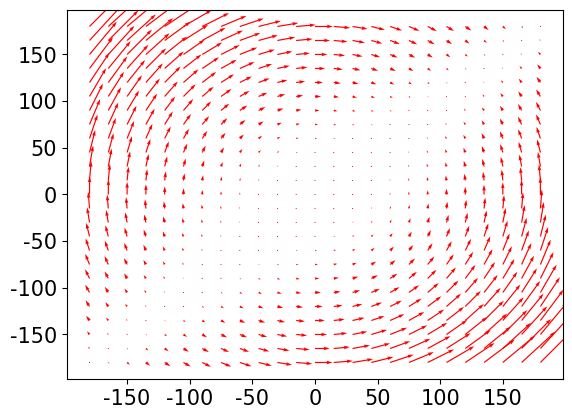

In [ ]:
# Create the dynanimc model and set up all parameters.


import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

def W_x(x,y,z):

  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):

  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)
X,Y,U,V = model.plot(-180,-180,180,180,0,25)

plt.quiver(X,Y,U,V, color="red")

# Show plot with grid
#plt.grid()

#plt.xlabel("x")
#plt.ylabel("y")
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)
plt.show()




In [ ]:
x,y,z = 10,10,100
plt.plot(x,y,  "k*")
x,y,z = model.step(0, 100, x, y, z)
plt.plot(x,y, "r*")
plt.show()

In [ ]:
for x in np.linspace(-200,200,20):
  for y in np.linspace(-200,200,20):
    plt.plot(x,y,  "k*")
    a,b,z = model.step(0, 1000, x, y, 100)
    plt.plot(a,b, "r*")
plt.show()

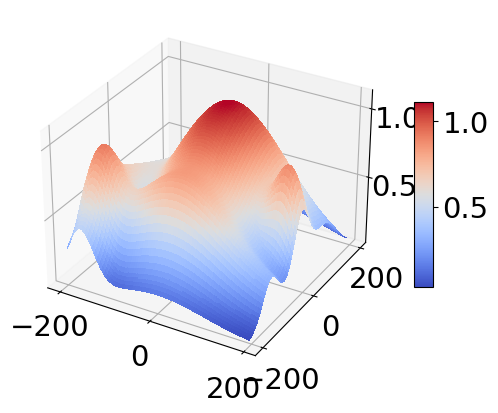

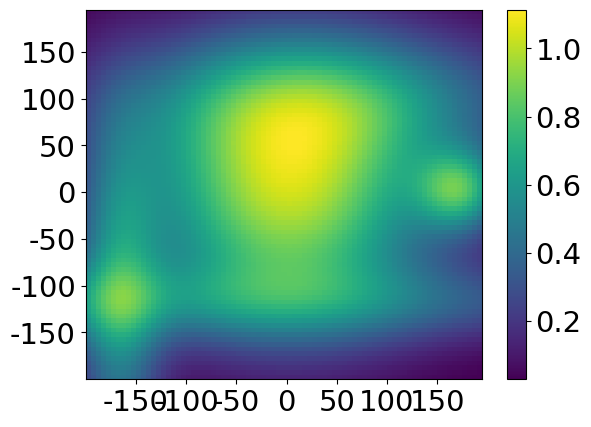

In [ ]:
# Create the ground truth

from matplotlib import cm

def guassian_function(A, x, y, x_0, y_0, std_x, std_y):
  return A* np.exp(- (x-x_0)**2/(2*std_x**2) - (y-y_0)**2/(2*std_y**2))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-200, 200, 5)
Y = np.arange(-200, 200, 5)
X, Y = np.meshgrid(X, Y)

Z = guassian_function(1,X,Y,0,0,100,100) + guassian_function(0.6,X,Y,170,0,30,30) + guassian_function(0.5,X,Y,-170,-120,30,130) + guassian_function(0.3,X,Y,-170,-120,630,30) + guassian_function(0.4,X,Y,50,100,150,50)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)


plt.figure(2)

Z = Z[:-1, :-1]


c = plt.pcolormesh(X, Y, Z,)
plt.colorbar(c)

x_label = np.arange(-150,151,50)

plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

Z = guassian_function(1,X,Y,0,0,100,100) + guassian_function(0.6,X,Y,170,0,30,30) + guassian_function(0.5,X,Y,-170,-120,30,130) + guassian_function(0.3,X,Y,-170,-120,630,30) + guassian_function(0.4,X,Y,50,100,150,50)


In [ ]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

x = np.vstack([X.ravel(), Y.ravel()]).transpose()
Z_shape = Z.shape

y = Z.reshape((-1,1))
kernel = RBF(1)
gpr = GaussianProcessRegressor(kernel=kernel,
                               random_state=0).fit(x[0::10,:], y[0::10,:])
score = gpr.score(x, y)
print(score)
print(gpr.kernel_.get_params())

Z_prime = gpr.predict(x, return_std=False)
Z_prime = Z_prime.reshape(Z_shape)
#print(Z_prime.shape)

surf = ax.plot_surface(X, Y, Z_prime, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


c = plt.pcolormesh(X, Y, Z_prime, cmap ='Blues')
plt.title("Predicted field")
plt.colorbar(c)

plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.9945992443207702
{'length_scale': 49.811566444297966, 'length_scale_bounds': (1e-05, 100000.0)}


AttributeError: ignored

In [ ]:
gpr.kernel_
print(gpr.get_params())
print(gpr.kernel_)

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': [1, 1], 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel': RBF(length_scale=[1, 1]), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0}
RBF(length_scale=[1, 49.4])


In [ ]:
# Create the problem

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(1,7.3e2,2, kernal = gpr.kernel_)
print(P)
Problem.visualize(P)

P = Problem.planner(2,1e5,6, kernal = gpr.kernel_)
print(P)
Problem.visualize(P)

In [ ]:

Gp = nx.Graph()
for i in G.get_nodes():
  Gp.add_node(i , pos = G.get_pos(i))
pos = nx.get_node_attributes(Gp, "pos")


H = Gp.copy()


# Calculating the distances between the nodes as edge's weight.
for i in pos.keys():
    for j in pos.keys():
        if not i == j:
          dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
          dist = dist
          Gp.add_edge(i, j, weight=dist)

cycle = nx_app.christofides(Gp, weight="weight")
print(cycle)
edge_list = list(nx.utils.pairwise(cycle))
print(edge_list)


# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    Gp,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

print("The route of the traveller is:", cycle)
plt.show()

#

[{'V15', 'V9', 'V0'}, {'V0', 'V8', 'V10'}]


([<matplotlib.axis.YTick at 0x7fe7de1c5d50>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

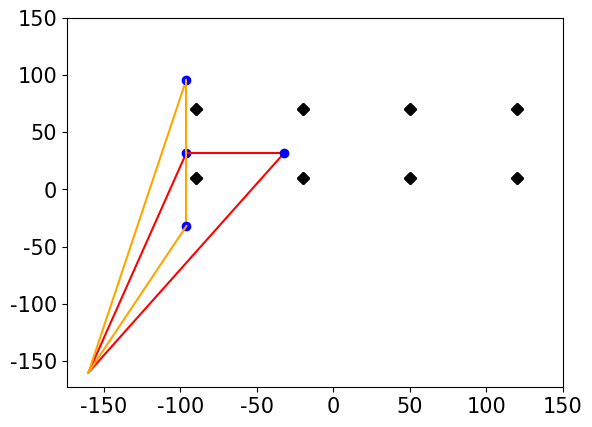

In [ ]:
# Expriement 1: Deterministc (Do not have wind, small budget)

# Definie PoIs
#PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]
PoIs = [(-90, 10),(-20,10),(50,10), (120,10), (-90,70),(-20,70),(50,70), (120, 70)]
# Definie Wind Field
def W_x(x,y,z):
  return 0
def W_y(x,y,z):
  return 0

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)


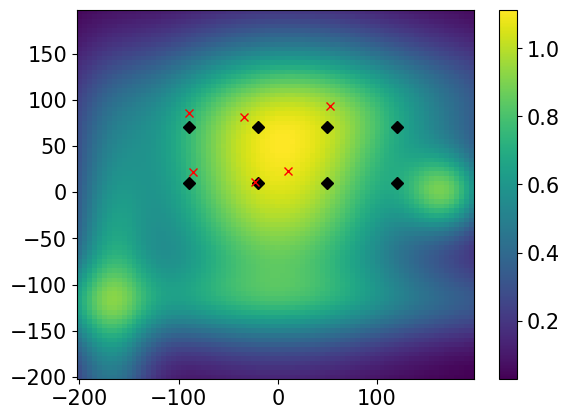

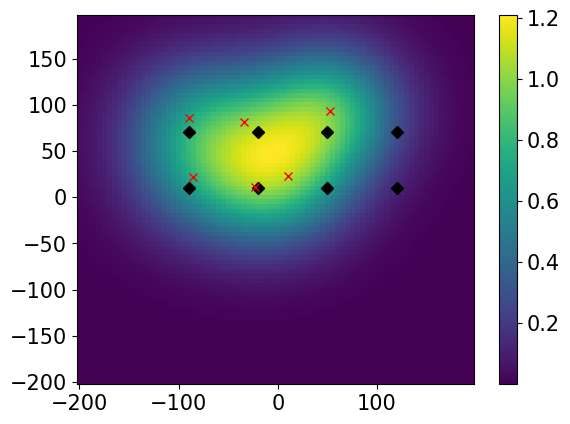

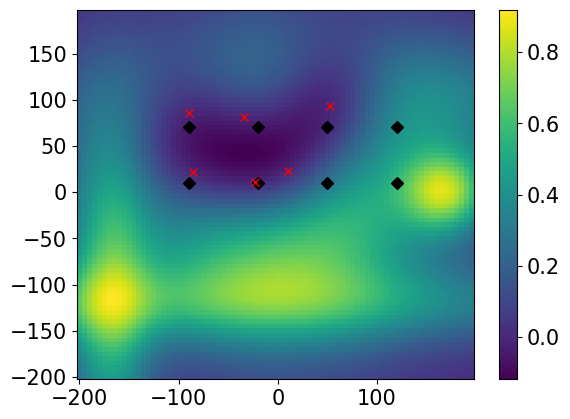

[0.80691569]


In [ ]:
def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)



X = np.arange(-200, 200, 5)
D = len(X)
Y = np.arange(-200, 200, 5)
Z = [[x,y] for y in Y for x in X]

Z_compare = np.array([measurement(x,y) for y in Y for x in X])


X, Y = np.meshgrid(X, Y)
K = set()
for item in P:
    for e in item:
      K.add(e)
K = K - set(['V0'])

m, Z, S_pos = Problem.Prediction(K, gpr.kernel_, Z, measurement)

Z = Z.diagonal()
Z = Z.reshape((D,D))
'''
c = plt.pcolormesh(X, Y, Z)
#plt.title("Variance")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")

plt.show()
'''

Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare )
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

m = m.reshape((D,D))
c = plt.pcolormesh(X, Y, m, )
#plt.title("Mean")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare - m)
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

total_error = 0
for i in range(300):
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/300)

In [ ]:
1.25993485 # D no 2 small
1.1140586  # D no 4 small
1.11252215 # D no 6 small
1.21580266 # D no 2 med
0.35897218 # D no 4 med
0.28403965 # D no 6 med
1.21580266 # D no 2 high
0.19927022 # D no 4 high
0.30189315 # D no 6 high


0.60954543 # D W 2 small
0.57839354 # D W 4 small
0.57839354 # D W 6 small
0.68708734 # D W 2 high
0.45959059 # D W 4 high
0.36576903 # D W 6 high

In [ ]:
# Do not have wind and 4 sensor,small budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 6 sensor and small budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 2 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 4 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 6 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 2 sensor and enough budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 4 sensor
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Do not have wind and 6 sensor
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# have wind and 2 sensor and S budget

def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000


model = Wind_model(W_x, W_y, m_c, rho,kappa)
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# have wind and 4 sensor and M budget

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

[{'V9', 'V15', 'V8', 'V13', 'V20', 'V0'}, {'V16', 'V0', 'V14', 'V7'}]


([<matplotlib.axis.YTick at 0x7fe8280581c0>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

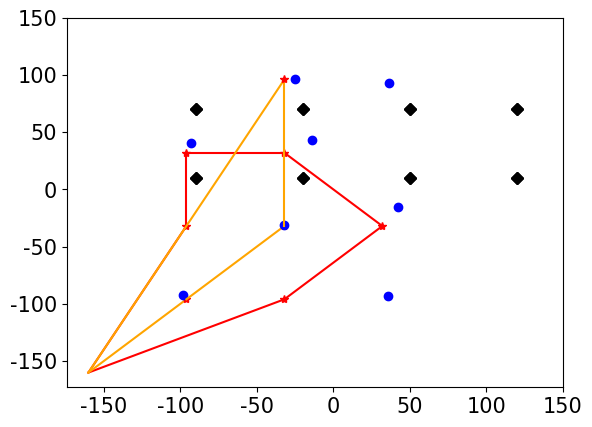

In [ ]:
# have wind and 6 sensor and M budget

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# have wind and 2 sensor and L budget
t1_start = process_time()
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,2, kernal = gpr.kernel_)
t1_stop = process_time()
print(t1_stop - t1_start)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# have wind and 4 sensor and L budget
t1_start = process_time()

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,4, kernal = gpr.kernel_)
t1_stop = process_time()
print(t1_stop - t1_start)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

1.0238675969056767 1.023874005309189
1.0238675969056767 1.030567707741035
1.0238675969056767 1.334084548825636
1.0238675969056767 1.0479017702510076
1.0238675969056767 2.058783762667813
1.0238675969056767 1.4110035428794219
1.0238675969056767 1.0277571181097849
1.0238675969056767 1.3801755648820875
1.0238675969056767 1.092518625836184
1.0238675969056767 1.0308831340425137
1.0238675969056767 1.0301882774462932
1.0238675969056767 1.023871714943766
1.0238675969056767 1.4196814277629208
1.0238675969056767 1.4001176791104668
1.0238675969056767 1.023873315301378
1.0238675969056767 1.715992669446287
1.0238675969056767 1.4120586250849068
1.0238675969056767 1.8138950291495848
1.0238675969056767 1.7756960251009102
1.0238675969056767 1.0251670073577168
1.0238675969056767 1.0475934916769625
1.0238675969056767 1.2125611176250766
1.0238675969056767 1.0304275982651971
1.0238675969056767 1.0276262803196612
1.0238675969056767 2.4099318202654376
1.0238675969056767 1.0375439357888276
1.0238675969056767 2

([<matplotlib.axis.YTick at 0x7fe860ac3a00>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

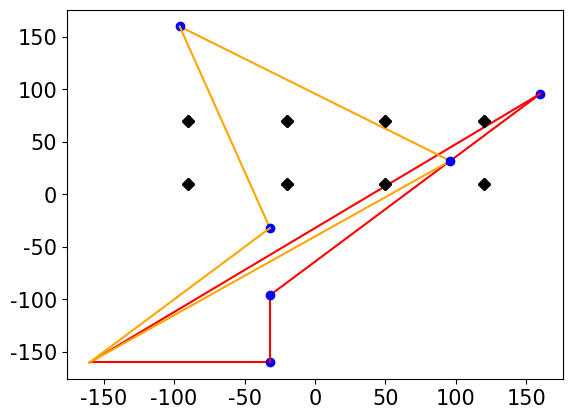

In [ ]:
# have wind and 6 sensor and L budget
t1_start = process_time()

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,3, kernal = gpr.kernel_)
t1_stop = process_time()
print(t1_stop - t1_start)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

[{'V0', 'V12', 'V8'}, {'V0', 'V7', 'V3'}]


([<matplotlib.axis.YTick at 0x7f0f14726500>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

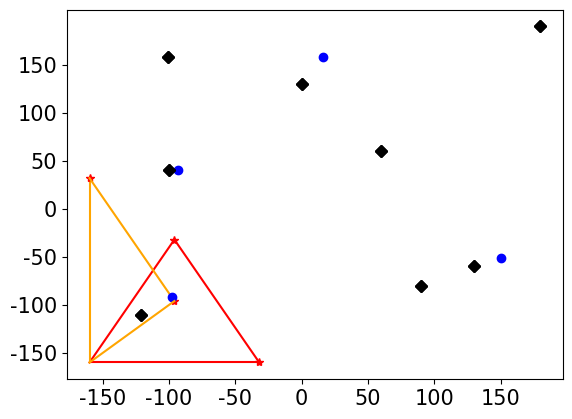

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,6e2,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,2, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Expriement 2: stoch (Do not have wind, small budget)

# Definie PoIs
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)


Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,1.2e3,6, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
# Exprimenet 3 (different number of sensors)
labels = []
timers = []
for i in range(1,8):
  labels.append(str(i))
  timer = []
  for j in range(1):
    t1_start = process_time()

    Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

    P = Problem.planner(2,1.2e3,i, kernal = gpr.kernel_)
    t1_stop = process_time()
    timer.append(t1_stop - t1_start)

  timers.append(timer)
  print(timers)
plt.boxplot(timers, labels= labels)


In [ ]:
# Number of Agents
labels = []
timers = []
for i in range(1,9):
  labels.append(str(i))
  timer = []
  for j in range(1):
    t1_start = process_time()

    Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

    P = Problem.brute_force(i,1.2e3,2, kernal = gpr.kernel_)
    t1_stop = process_time()
    timer.append(t1_stop - t1_start)

  timers.append(timer)
  print(timers)
plt.boxplot(timers, labels= labels)

In [ ]:
# Number of PoIs
import random
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes

labels = []
timers = []
for i in range(2,9):
  labels.append(str(i))
  timer = []
  for j in range(1):
    PoIs_temp = random.sample(PoIs, i)
    t1_start = process_time()

    Problem = MSD(model, G, PoIs_temp, z, "V0", "V0", t_start, t_end)

    P = Problem.brute_force(2,1.2e3,2, kernal = gpr.kernel_)
    t1_stop = process_time()
    timer.append(t1_stop - t1_start)

  timers.append(timer)
  print(timers)
boxplot(timers, positions=[1,2], widths = 0.6, labels= labels)
#boxplot(timers, positions=[4,5], widths = 0.6)

In [ ]:
Problem = MSD(model, G, PoIs_temp, z, "V0", "V0", t_start, t_end)
P = Problem.brute_force(2,1.2e3,2, kernal = gpr.kernel_)

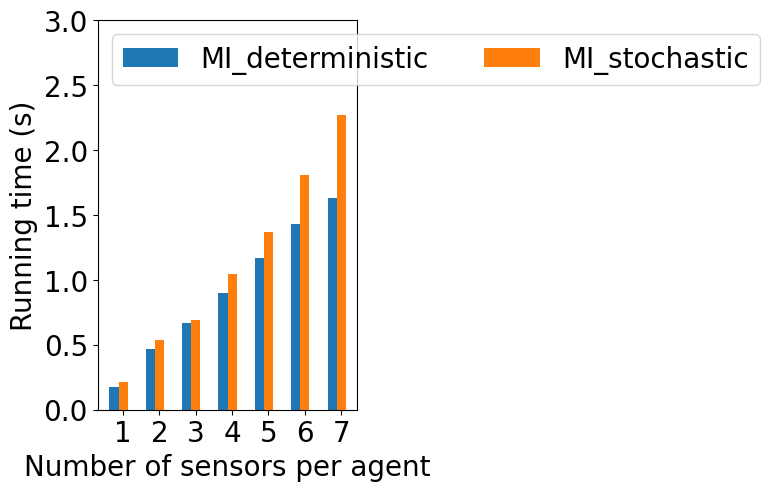

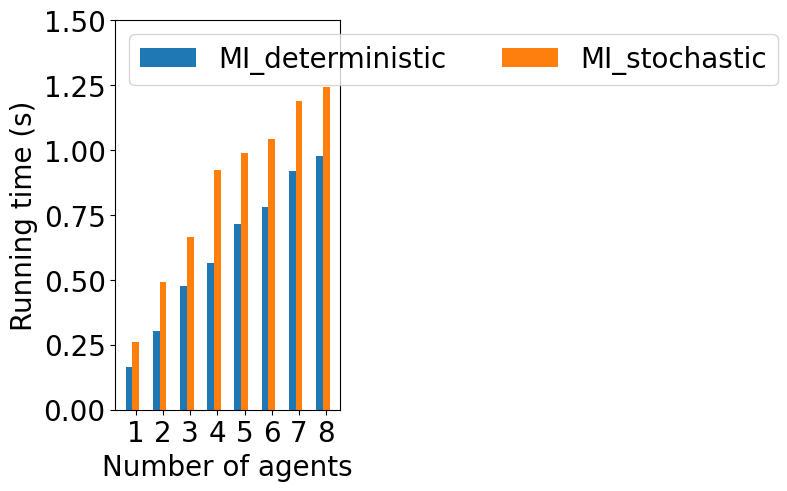

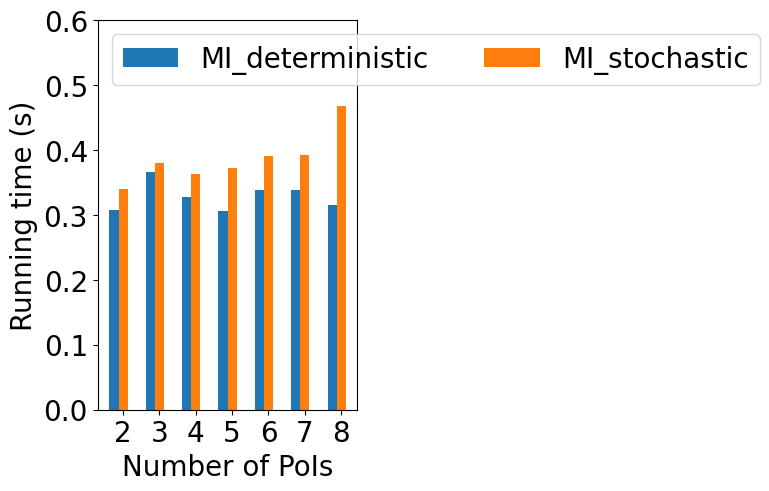

In [ ]:
# Sensors (2,11,2)
D1 = (0.17792513399945165, 0.4667686530010542, 0.6715906650006218, 0.8968114819999755, 1.166480257999865, 1.4332128660007584, 1.6291187779988832)

S1 = (0.21564613100053975, 0.5393346799992287, 0.6938476369996351, 1.0482819419994485, 1.3682477040001686, 1.8108363589999499, 2.268383339000138)
#B1 = (0.9008038209994993,300.9284503480003, 0, 0, 0, 0, 0)

# Agent (1,9)
D2 = (0.16437445500014292, 0.30188270100006775, 0.47712544400019397, 0.5660536799987312, 0.716830540999581, 0.7807490670002153, 0.9207257580001169, 0.9792674210002588)
S2 = (0.26278556899887917, 0.49133250299928477, 0.6657642450009007, 0.9230951900008222, 0.9902301900001476, 1.041201379000995, 1.191048568000042, 1.2414790220009309)
#B2 = (1.0817128590006178, 296.6541526070014, 0, 0, 0, 0, 0)


# PoIs (2,9)
D3 = (0.3078475089987478, 0.366798541001117, 0.3271826959989994, 0.3055771179988369, 0.3384629859992856, 0.3387432870003977, 0.31520863699915935)
S3 = (0.34075821499936865, 0.3797054320002644, 0.36302614400119637, 0.37192510000022594, 0.3907561269988946, 0.392576239999471, 0.4682999250017019)
#B3 = (297.6622039800004, 294.74368006900113, 293.97242700900097, 299.7029361500008, 297.5832018710007, 319.6845865230007, 311.5357109460001)


# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = [i for i in range(1,8)]
penguin_means = {
    'MI_deterministic': D1,
    'MI_stochastic': S1,
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Running time (s)')
ax.set_xlabel('Number of sensors per agent')
ax.set_title("")
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 3)
plt.show()


species = [i for i in range(1,9)]
penguin_means = {
    'MI_deterministic': D2,
    'MI_stochastic': S2,
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Running time (s)')
ax.set_title("")
ax.set_xlabel('Number of agents')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.5)

plt.show()

species = [i for i in range(2,9)]
penguin_means = {
    'MI_deterministic': D3,
    'MI_stochastic': S3,
}


x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Running time (s)')
ax.set_xlabel('Number of PoIs')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.6)
plt.show()


# Instance. Wind and stochostic and approximation


---



# New Section

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import process_time
from itertools import combinations

# The Class MSD is the main problem and contains all necessary parameters

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


from pandas.io.formats.style_render import non_reducing_slice
class MSD:
  def __init__(self, Wind_model, graph=None, pois=set(), z=0, V_start='a', V_end='a', t_start=0, t_end = 1, norm = 800):
    self.graph = graph
    self.pois = pois
    self.V_start = V_start
    self.V_end = V_end
    self.t_end = t_end
    self.t_start = t_start
    self.norm = 1
    self.z = z

    self.dynamic_model = Wind_model

  def MI_distance(self, S):
    total_reward = 0

    for s in S:
      reward = 0
      (x,y) = self.graph.get_pos(s)
      (x,y,z) = self.dynamic_model.step(self.t_start, self.t_end, x, y, self.z)
      for poi in self.pois:
        reward += self.distance(poi[0], poi[1], x, y)

      total_reward += 1/reward

    return total_reward

  # A function to compute Mutual Information
  def Prediction(self, S, kernel, y, measurement, noise_coviance=400):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = np.array(y)


    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    return mean, variance, S_pos

  def error(self, S, kernel, measurement, noise_coviance=400):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm+0.001])
    POI_pos = np.array(POI_pos)


    #variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    #,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    error =0

    for i in range(POI_pos.shape[0]):

      pos = POI_pos[i]
      value = measurement(pos[0]/self.norm, pos[1]/self.norm)

      error += (value-mean[i])**2

    return error**0.5

  # A function to compute Mutual Information
  def MI(self, S, kernel):

    D = len(self.pois)

    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    #print(variance)
    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)


  # A function to compute Mutual Information
  def MI_stochastic(self, S, kernel, W=(49.8**2), noise_coviance=400):

    D = len(self.pois)

    # Convert the sensor set to position array
    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    # Convert the PoIs set to position array
    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    # Appoximation
    Kernel_A = kernel(POI_pos, S_pos)
    Kernel_B = kernel(S_pos, S_pos)

    for i in range(len(POI_pos)):
      for j in range(len(S)):
        x_diff = (POI_pos[i] - S_pos[j])
        numerator  = 1/(W+  noise_coviance)
        determinator = 1+ ( 1/W * noise_coviance)

        Kernel_A[i,j] = np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    for i in range(len(S)):
      for j in range(len(S)):
        if not i == j:
          x_diff = (S_pos[i] - S_pos[j])
          numerator  = 1/(W+  2*noise_coviance)
          determinator = 1+ ( 1/W * 2*noise_coviance)

          Kernel_B[i,j] =  np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    Kernel_C = Kernel_A.transpose()

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul( Kernel_A
    ,np.linalg.inv(Kernel_B)) , Kernel_C)

    #print(np.linalg.det(variance))

    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)

  # Different solvers to solve the main problem
  def planner(self, n_agents, budget, n_sensor, method="D", kernal=50):
    if method == "D":

      return self.SGA(budget, n_sensor, n_agents, kernal)

    if method == "S":
      pass


    path = [("V0",0)]
    return path


  # Computer the cost
  def cost(self, S):
    edge_list = self.TSP_solver(S)

    total_cost = 0
    for edge in edge_list:
      x1,y1 = self.graph.get_pos(edge[0])
      x2,y2 = self.graph.get_pos(edge[1])
      total_cost += self.distance(x1,y1,x2,y2)
    return total_cost

  def TSP_solver(self, S):
    Gp = nx.Graph()
    for i in S:
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(Gp, weight="weight")
    edge_list = list(nx.utils.pairwise(cycle))

    return edge_list

  def distance(self, x1, y1, x2, y2):
    return sqrt((x1-x2)**2 + (y1-y2)**2)


  def SGA(self, budget, n_sensor, n_agents, kernal = 0):
    A = set()
    P = []
    for i in range(n_agents):
      P.append(self.GCB(A, budget, n_sensor, kernal))
      A.update(P[-1])

    return P

  def GCB(self, A, budget, n_sensor, kernal = 0):
    S = set([self.V_start])
    V_prime = set(self.graph.get_nodes())

    V_prime = V_prime - A
    V_prime = V_prime - S

    while len(V_prime) and n_sensor > 0:
      max_reward = -float('inf')
      max_node = None

      for i in V_prime:
        G = S.copy()
        G.add(i)

        #print(self.MI_stochastic(G, kernal), self.MI(G, kernal))
        reward = self.MI_stochastic(G, kernal) - self.MI_stochastic(S, kernal)
        #print(G, self.MI(G, kernal))
        if len(S) == 1:
          cost1 =  self.cost(G) + 500
        else:
          cost1 =  self.cost(G) - self.cost(S) + 500


        if reward/cost1 > max_reward:
          max_reward = reward/cost1
          max_node = i

      G = S.copy()
      G.add(max_node)

      #print(G)
      if  self.cost(G) <= budget:
        S.add(max_node)
        n_sensor -= 1

      V_prime = V_prime - (set([max_node]))
    return S

  def brute_force(self, n_agents, budget, n_sensor, method="D", kernal=0):
    P = []
    max_reward = -float('inf')
    P_prime = [set(self.V_start)]


    for i in range(n_agents):
      temp = []
      for j in P_prime:
        V_prime = set(self.graph.get_nodes()) - j
        for k in [com for com in combinations(V_prime, n_sensor)]:
          k = set(k)
          k.add(self.V_start)
          if self.cost(k) <= budget:
            temp.append(k)
      P_prime = temp

    for j in P_prime:
      reward = self.MI(j, kernal)
      if  reward > max_reward:
        P = j
        max_reward = max_reward

    return P

  def visualize(self, S):
    fig, ax = plt.subplots()
    Gp = nx.Graph()

    for i in G.get_nodes():
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    colors = [ "red", "orange", "purple", "yellow"]
    for S_S, color in zip(S,colors):
      edge_list = self.TSP_solver(S_S)
      #print(edge_list)

      for edge in edge_list:
        point_a = G.get_pos(edge[0])
        point_b = G.get_pos(edge[1])
        ax.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], color=color)
        if not edge[1] == self.V_start:
          ax.plot(point_b[0], point_b[1], "*r")
          point_b = self.dynamic_model.step(self.t_start, self.t_end, point_b[0], point_b[1], self.z)
          #ax.plot(point_b[0], point_b[1], "bo")

      for PoI in self.pois:
        ax.plot(PoI[0],PoI[1],"kD")
      '''
      # Draw the route
      nx.draw_networkx(
          Gp,
          pos,
          with_labels=True,
          edgelist=edge_list,
          edge_color="red",
          node_size=200,
          width=3,
      )
      '''
    return ax


In [ ]:
# The Class graph create the graph network for the vis

import networkx as nx

class graph:
  def __init__(self,gdict=None):
      self.gdict = {}    # A dict of (node1, node2)
      self.edict = {}   # A dict of ((node1, node2), edge)
      self.ndict = {}   # A dict of (node, position)

  # Add the new node
  def AddNode(self, nodes, values):
    if not (node in self.ndict):
      self.ndict[node] = value

  # Add the new edge
  def AddEdge(self, edge, cost):
    edge = set(edge)
    (vrtx1, vrtx2) = tuple(edge)
    if vrtx1 in self.gdict:
      self.gdict[vrtx1].append(vrtx2)
    else:
      self.gdict[vrtx1] = [vrtx2]

    if vrtx2 in self.gdict:
      self.gdict[vrtx2].append(vrtx1)
    else:
      self.gdict[vrtx2] = [vrtx1]


    self.edict[(vrtx1, vrtx2)] = cost
    self.edict[(vrtx2, vrtx1)] = cost

  # List the edge names
  def edges(self):
    edgename = []
    for vrtx in self.gdict:
      for nxtvrtx in self.gdict[vrtx]:
        if {nxtvrtx, vrtx} not in edgename:
          edgename.append({vrtx, nxtvrtx})
    return edgename

  # List all nodes
  def get_nodes(self):
      return self.gdict.keys()

  # Display the graph as a List
  def get_gdict(self):
      return self.gdict

  # Get the cost from node1 to node2
  def get_cost(self, vrtx1, vrtx2):
    return self.edict[(vrtx1, vrtx2)]

  # Get all edges at the node
  def get_edges(self, vrtx):
    if vrtx in self.gdict:
      return self.gdict[vrtx]
    return []

  # the the position of the node
  def get_pos(self, vrtx):
    if vrtx in self.ndict:
      return self.ndict[vrtx]
    return []
  '''
  def visualize(self):
    G = nx.Graph()

    for vrtx in self.gdict:
      for vrtx2 in self.gdict[vrtx]:
        G.add_edges_from((vrtx, vrtx2))

    #pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos=self.ndict)
    nx.draw_networkx_labels(G, pos=self.ndict)
    #nx.draw_networkx_edges(G, pos, edge_color = 'tab:red')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = get_edge_labels(G))
    #nx.draw_networkx_edge_labels(G,pos)

    plt.show()
  '''

In [ ]:
from pandas.core.groupby.groupby import T
# The Class Wind_model models the DYNAMICS OF AIRDROP
class Wind_model:
  def __init__(self, W_x, W_y, m_c, rho, kappa,  T=1, g=9.8):

    self.W_x = W_x
    self.W_y = W_y

    self.m_c = m_c
    self.rho = rho
    self.kappa = kappa

    self.T = T
    self.g = g


  # Compute the 3-d position at t_end
  def step(self, t, t_end, x_0, y_0, z_0, uncetain=(0,0)):
    x = x_0
    y = y_0
    z = z_0
    z_dot = 0

    while t <= t_end and z >= 0:
      #print(t,x,y,z)
      x = x + self.W_x(x,y,z) * self.T
      y = y + self.W_y(x,y,z) * self.T

      extra_force = self.g - 1/(0.5*self.m_c)* self.rho * self.kappa * (z_dot**2)
      z = z + z_dot * self.T - 0.5* extra_force * (self.T**2)
      z_dot = z_dot - extra_force *self.T

      t = t + self.T

    if uncetain == (0,0):
      return x,y,z
    mean, std = uncetain
    x = x + np.random.normal(mean, std)
    y = y + np.random.normal(mean, std)
    return x,y,z


  # Visualize the possible drop points
  def plot(self, x_low, y_low, x_high, y_high, z, samples):

    x = np.linspace(x_low, x_high, samples)
    y = np.linspace(y_low, y_high, samples)
    X,Y = np.meshgrid(x,y)
    U = W_x(X,Y,z)
    V = W_y(X,Y,z)


    return X,Y,U,V


In [ ]:
# Create Graph and PoIs. Also, visualize the graph.

G = graph()
Nodes = ["V"+str(i) for i in range(0,36)]
#values = [(0,0), (0,13), (31,13), (82, 16), (180, 170), (150,110),(-100,-20),(50,-90),(90,-120),(160,-85),(-160,-5),(-80,-70),(71,120),(-66,-110),(-9,135),(90,-70)]
#edges = [("V0","V1",2), ("V0","V2",4), ("V0","V7",5), ("V0","V11",10), ("V1","V12",11), ("V1","V6",7),
#("V6","V10",1), ("V6","V11",2), ("V11","V13",5), ("V10","V13",8),("V13","V8",16),("V8","V15",3), ("V7","V15",7)
# ,("V15","V3",7),("V15","V9",6), ("V9","V5",19), ("V5","V4",11), ("V4","V14",7), ("V14","V10",24), ("V3","V5",14), ("V5","V12",5),("V3","V2",8)]


values = [(i,j) for i in np.linspace(-160,160, 6) for j in np.linspace(-160,160, 6)]
edges = [("V"+str(i), "V"+str(i+1),1)  for j in range(0,36,6) for i in range(j,j+5)] +[ ("V"+str(i), "V"+str(i+6),1)  for j in range(0,30,6) for i in range(j,j+6)]


PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190)]
#PoIs = [(32,96),(96,96),(96,32), (32,32), (32,-32),(96,-32)]

for node, value in zip(Nodes,values):
  G.AddNode(node,value)


for e in edges:
  G.AddEdge((e[0],e[1]),e[2])



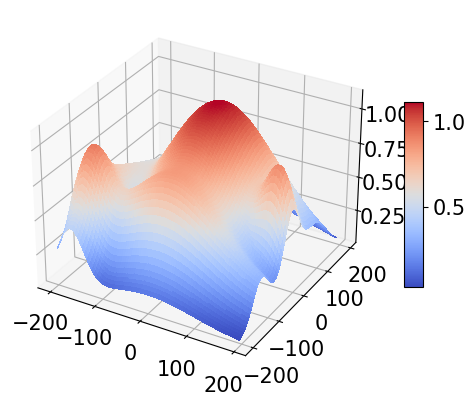

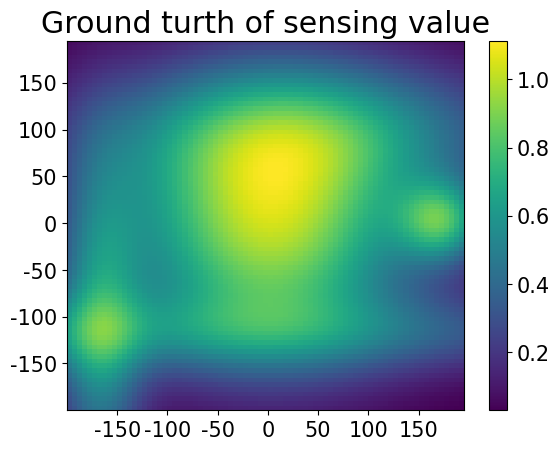

In [ ]:
# Create the ground truth

from matplotlib import cm



def guassian_function(A, x, y, x_0, y_0, std_x, std_y):
  return A* np.exp(- (x-x_0)**2/(2*std_x**2) - (y-y_0)**2/(2*std_y**2))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-200, 200, 5)
Y = np.arange(-200, 200, 5)
X, Y = np.meshgrid(X, Y)

Z = guassian_function(1,X,Y,0,0,100,100) + guassian_function(0.6,X,Y,170,0,30,30) + guassian_function(0.5,X,Y,-170,-120,30,130) + guassian_function(0.3,X,Y,-170,-120,630,30) + guassian_function(0.4,X,Y,50,100,150,50)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)


plt.figure(2)

Z = Z[:-1, :-1]


#c = plt.pcolormesh(X, Y, Z, cmap ='Blues')
c = plt.pcolormesh(X, Y, Z,  clip_box = None)
plt.title("Ground turth of sensing value", fontsize = "x-large")
plt.colorbar(c)

x_label = np.arange(-150,151,50)

plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

Z = guassian_function(1,X,Y,0,0,100,100) + guassian_function(0.6,X,Y,170,0,30,30) + guassian_function(0.5,X,Y,-170,-120,30,130) + guassian_function(0.3,X,Y,-170,-120,630,30) + guassian_function(0.4,X,Y,50,100,150,50)


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.9945992443207702
{'length_scale': 49.811566444297966, 'length_scale_bounds': (1e-05, 100000.0)}


([<matplotlib.axis.YTick at 0x7999444ff100>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

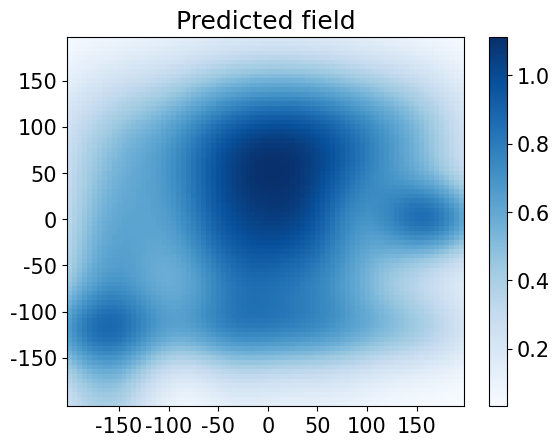

In [ ]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

x = np.vstack([X.ravel(), Y.ravel()]).transpose()
Z_shape = Z.shape

y = Z.reshape((-1,1))
kernel = RBF(1)
gpr = GaussianProcessRegressor(kernel=kernel,
                               random_state=0).fit(x[0::10,:], y[0::10,:])
score = gpr.score(x, y)
print(score)
print(gpr.kernel_.get_params())

Z_prime = gpr.predict(x, return_std=False)
Z_prime = Z_prime.reshape(Z_shape)
#print(Z_prime.shape)

surf = ax.plot_surface(X, Y, Z_prime, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


c = plt.pcolormesh(X, Y, Z_prime, cmap ='Blues')
plt.title("Predicted field")
plt.colorbar(c)

plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
PoIs = [(0,130),(60,60),(-100,40), (90,-80), (130,-60),(180,190),(-101,158), (-121, -111)]

# Definie Wind Field
def W_x(x,y,z):
  return (-x + 2*y - x*y + y*y)/3000
def W_y(x,y,z):
  return (-3*x + x*x - x*y)/3000

# All parameters
m_c = 10
rho = 1
kappa = 1
t_start = 0
t_end = 10000
B = 100
z = 100

model = Wind_model(W_x, W_y, m_c, rho,kappa)

[{'V12', 'V0', 'V7', 'V22', 'V8'}, {'V16', 'V27', 'V0', 'V2', 'V19'}]


([<matplotlib.axis.YTick at 0x799942314370>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

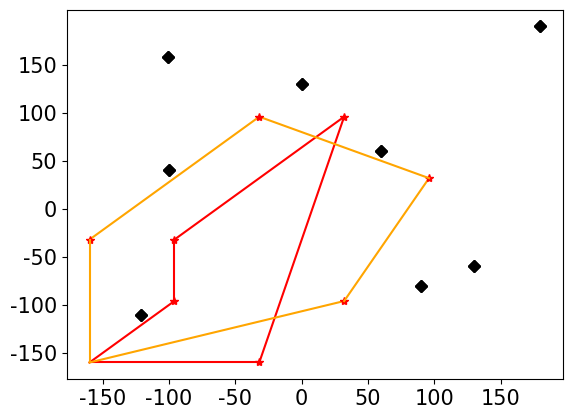

In [ ]:
# Do not have wind and 4 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

In [ ]:
def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)



X = np.arange(-200, 200, 5)
D = len(X)
Y = np.arange(-200, 200, 5)
Z = [[x,y] for y in Y for x in X]

Z_compare = np.array([measurement(x,y) for y in Y for x in X])


X, Y = np.meshgrid(X, Y)
K = set()
for item in P:
    for e in item:
      K.add(e)
K = K - set(['V0'])

m, Z, S_pos = Problem.Prediction(K, gpr.kernel_, Z, measurement)

Z = Z.diagonal()
Z = Z.reshape((D,D))
'''
c = plt.pcolormesh(X, Y, Z)
#plt.title("Variance")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")

plt.show()
'''

Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare )
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

m = m.reshape((D,D))
c = plt.pcolormesh(X, Y, m, )
#plt.title("Mean")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare - m)
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

total_error = 0
for i in range(1000):
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/1000)

In [ ]:
from random import sample
def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)

Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

total_error = 0
for i in range(1000):
  P = sample(list(Problem.graph.get_nodes()), 8)
  K = set(P)
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/1000)

# Instance. Wind and stochoostic

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import process_time
from itertools import combinations

# The Class MSD is the main problem and contains all necessary parameters

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


from pandas.io.formats.style_render import non_reducing_slice
class MSD:
  def __init__(self, Wind_model, graph=None, pois=set(), z=0, V_start='a', V_end='a', t_start=0, t_end = 1, norm = 400):
    self.graph = graph
    self.pois = pois
    self.V_start = V_start
    self.V_end = V_end
    self.t_end = t_end
    self.t_start = t_start
    self.norm = 1
    self.z = z

    self.dynamic_model = Wind_model

  def MI_distance(self, S):
    total_reward = 0

    for s in S:
      reward = 0
      (x,y) = self.graph.get_pos(s)
      (x,y,z) = self.dynamic_model.step(self.t_start, self.t_end, x, y, self.z)
      for poi in self.pois:
        reward += self.distance(poi[0], poi[1], x, y)

      total_reward += 1/reward

    return total_reward

  # A function to compute Mutual Information
  def Prediction(self, S, kernel, y, measurement, noise_coviance=900):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = np.array(y)


    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    return mean, variance, S_pos

  def error(self, S, kernel, measurement, noise_coviance=900):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm+0.001])
    POI_pos = np.array(POI_pos)


    #variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    #,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    error =0

    for i in range(POI_pos.shape[0]):

      pos = POI_pos[i]
      value = measurement(pos[0]/self.norm, pos[1]/self.norm)

      error += (value-mean[i])**2

    return error**0.5

  # A function to compute Mutual Information
  def MI(self, S, kernel):

    D = len(self.pois)

    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)


  # A function to compute Mutual Information
  def MI_stochastic(self, S, kernel, W=(49.8**2), noise_coviance=900):

    D = len(self.pois)

    # Convert the sensor set to position array
    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    # Convert the PoIs set to position array
    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    # Appoximation
    Kernel_A = kernel(POI_pos, S_pos)
    Kernel_B = kernel(S_pos, S_pos)

    for i in range(len(POI_pos)):
      for j in range(len(S)):
        x_diff = (POI_pos[i] - S_pos[j])
        numerator  = 1/(W+  noise_coviance)
        determinator = 1+ ( 1/W * noise_coviance)

        Kernel_A[i,j] = np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    for i in range(len(S)):
      for j in range(len(S)):
        if not i == j:
          x_diff = (S_pos[i] - S_pos[j])
          numerator  = 1/(W+  2*noise_coviance)
          determinator = 1+ ( 1/W * 2*noise_coviance)

          Kernel_B[i,j] =  np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    Kernel_C = Kernel_A.transpose()

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul( Kernel_A
    ,np.linalg.inv(Kernel_B)) , Kernel_C)



    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)

  # Different solvers to solve the main problem
  def planner(self, n_agents, budget, n_sensor, method="D", kernal=50):
    if method == "D":

      return self.SGA(budget, n_sensor, n_agents, kernal)

    if method == "S":
      pass


    path = [("V0",0)]
    return path


  # Computer the cost
  def cost(self, S):
    edge_list = self.TSP_solver(S)

    total_cost = 0
    for edge in edge_list:
      x1,y1 = self.graph.get_pos(edge[0])
      x2,y2 = self.graph.get_pos(edge[1])
      total_cost += self.distance(x1,y1,x2,y2)
    return total_cost

  def TSP_solver(self, S):
    Gp = nx.Graph()
    for i in S:
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(Gp, weight="weight")
    edge_list = list(nx.utils.pairwise(cycle))

    return edge_list

  def distance(self, x1, y1, x2, y2):
    return sqrt((x1-x2)**2 + (y1-y2)**2)


  def SGA(self, budget, n_sensor, n_agents, kernal = 0):
    A = set()
    P = []
    for i in range(n_agents):
      P.append(self.GCB(A, budget, n_sensor, kernal))
      A.update(P[-1])

    return P

  def GCB(self, A, budget, n_sensor, kernal = 0):
    S = set([self.V_start])
    V_prime = set(self.graph.get_nodes())

    V_prime = V_prime - A
    V_prime = V_prime - S

    while len(V_prime) and n_sensor > 0:
      max_reward = -float('inf')
      max_node = None

      for i in V_prime:
        G = S.copy()
        G.add(i)

        #print(self.MI_stochastic(G, kernal), self.MI(G, kernal))
        reward = self.MI(G, kernal) - self.MI(S, kernal)
        #print(G, self.MI(G, kernal))
        if len(S) == 1:
          cost1 =  self.cost(G) + 500
        else:
          cost1 =  self.cost(G) - self.cost(S) + 500


        if reward/cost1 > max_reward:
          max_reward = reward/cost1
          max_node = i

      G = S.copy()
      G.add(max_node)

      #print(G)
      if  self.cost(G) <= budget:
        S.add(max_node)
        n_sensor -= 1

      V_prime = V_prime - (set([max_node]))
    return S

  def brute_force(self, n_agents, budget, n_sensor, method="D", kernal=0):
    P = []
    max_reward = -float('inf')
    P_prime = [set(self.V_start)]


    for i in range(n_agents):
      temp = []
      for j in P_prime:
        V_prime = set(self.graph.get_nodes()) - j
        for k in [com for com in combinations(V_prime, n_sensor)]:
          k = set(k)
          k.add(self.V_start)
          if self.cost(k) <= budget:
            temp.append(k)
      P_prime = temp

    for j in P_prime:
      reward = self.MI(j, kernal)
      if  reward > max_reward:
        P = j
        max_reward = max_reward

    return P

  def visualize(self, S):
    fig, ax = plt.subplots()
    Gp = nx.Graph()

    for i in G.get_nodes():
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    colors = [ "red", "orange", "purple", "yellow"]
    for S_S, color in zip(S,colors):
      edge_list = self.TSP_solver(S_S)
      #print(edge_list)

      for edge in edge_list:
        point_a = G.get_pos(edge[0])
        point_b = G.get_pos(edge[1])
        ax.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], color=color)
        if not edge[1] == self.V_start:
          ax.plot(point_b[0], point_b[1], "*r")
          point_b = self.dynamic_model.step(self.t_start, self.t_end, point_b[0], point_b[1], self.z)
          #ax.plot(point_b[0], point_b[1], "bo")

      for PoI in self.pois:
        ax.plot(PoI[0],PoI[1],"kD")
      '''
      # Draw the route
      nx.draw_networkx(
          Gp,
          pos,
          with_labels=True,
          edgelist=edge_list,
          edge_color="red",
          node_size=200,
          width=3,
      )
      '''
    return ax


[{'V8', 'V12', 'V7', 'V22', 'V0'}, {'V27', 'V16', 'V21', 'V0', 'V2'}]


([<matplotlib.axis.YTick at 0x7f6f82912920>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

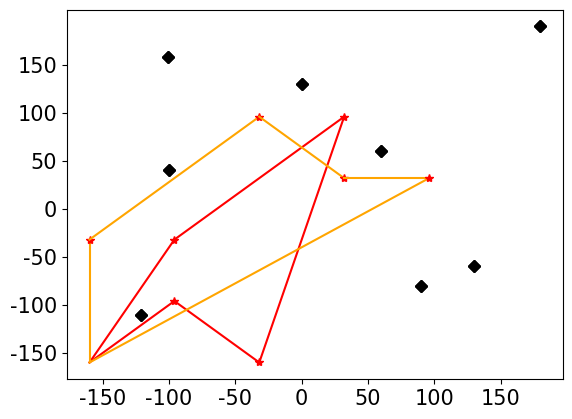

In [ ]:
# Do not have wind and 4 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986


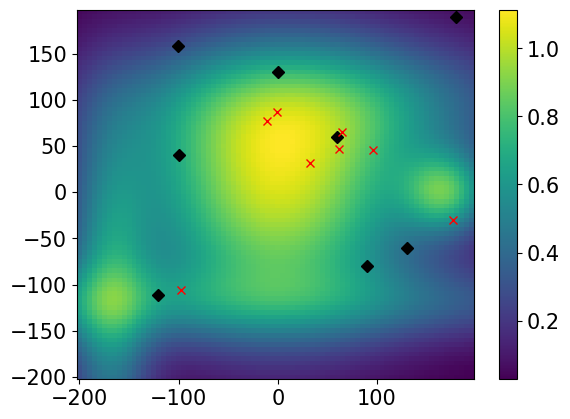

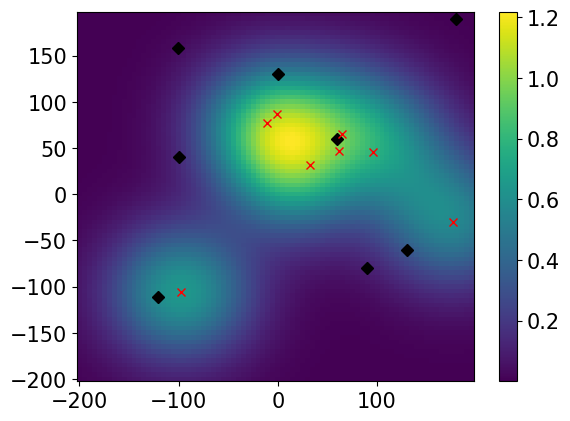

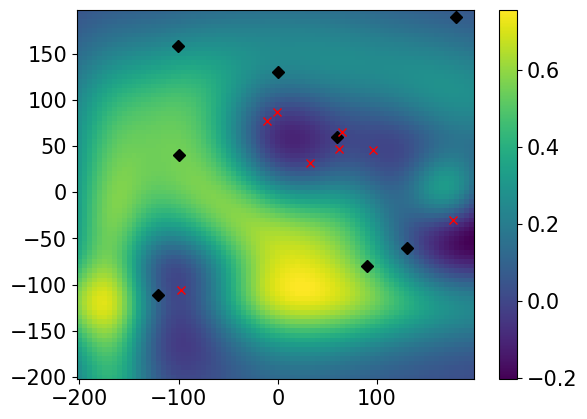

Streaming output truncated to the last 5000 lines.
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.952350887972333
4.637658612599832
3.961981718575571
1.9452013618256827
0.7943851887340986
0.02419284381464412
0.7553308482150494
0.35987141867061345
1.95

In [ ]:
def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)



X = np.arange(-200, 200, 5)
D = len(X)
Y = np.arange(-200, 200, 5)
Z = [[x,y] for y in Y for x in X]

Z_compare = np.array([measurement(x,y) for y in Y for x in X])


X, Y = np.meshgrid(X, Y)
K = set()
for item in P:
    for e in item:
      K.add(e)
K = K - set(['V0'])

m, Z, S_pos = Problem.Prediction(K, gpr.kernel_, Z, measurement)

Z = Z.diagonal()
Z = Z.reshape((D,D))
'''
c = plt.pcolormesh(X, Y, Z)
#plt.title("Variance")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")

plt.show()
'''

Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare )
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

m = m.reshape((D,D))
c = plt.pcolormesh(X, Y, m, )
#plt.title("Mean")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare - m)
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

total_error = 0
for i in range(1000):
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/1000)




# Example 2. Deterministic


In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import process_time
from itertools import combinations

# The Class MSD is the main problem and contains all necessary parameters

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


from pandas.io.formats.style_render import non_reducing_slice
class MSD:
  def __init__(self, Wind_model, graph=None, pois=set(), z=0, V_start='a', V_end='a', t_start=0, t_end = 1, norm = 400):
    self.graph = graph
    self.pois = pois
    self.V_start = V_start
    self.V_end = V_end
    self.t_end = t_end
    self.t_start = t_start
    self.norm = 1
    self.z = z

    self.dynamic_model = Wind_model

  def MI_distance(self, S):
    total_reward = 0

    for s in S:
      reward = 0
      (x,y) = self.graph.get_pos(s)
      (x,y,z) = self.dynamic_model.step(self.t_start, self.t_end, x, y, self.z)
      for poi in self.pois:
        reward += self.distance(poi[0], poi[1], x, y)

      total_reward += 1/reward

    return total_reward

  # A function to compute Mutual Information
  def Prediction(self, S, kernel, y, measurement, noise_coviance=820):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = np.array(y)


    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    return mean, variance, S_pos

  def error(self, S, kernel, measurement, noise_coviance=820):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm+0.001])
    POI_pos = np.array(POI_pos)


    #variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    #,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    error =0

    for i in range(POI_pos.shape[0]):

      pos = POI_pos[i]
      value = measurement(pos[0]/self.norm, pos[1]/self.norm)

      error += (value-mean[i])**2

    return error**0.5

  # A function to compute Mutual Information
  def MI(self, S, kernel):

    D = len(self.pois)

    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)


  # A function to compute Mutual Information
  def MI_stochastic(self, S, kernel, W=(49.8**2), noise_coviance=820):

    D = len(self.pois)

    # Convert the sensor set to position array
    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    # Convert the PoIs set to position array
    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    # Appoximation
    Kernel_A = kernel(POI_pos, S_pos)
    Kernel_B = kernel(S_pos, S_pos)

    for i in range(len(POI_pos)):
      for j in range(len(S)):
        x_diff = (POI_pos[i] - S_pos[j])
        numerator  = 1/(W+  noise_coviance)
        determinator = 1+ ( 1/W * noise_coviance)

        Kernel_A[i,j] = np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    for i in range(len(S)):
      for j in range(len(S)):
        if not i == j:
          x_diff = (S_pos[i] - S_pos[j])
          numerator  = 1/(W+  2*noise_coviance)
          determinator = 1+ ( 1/W * 2*noise_coviance)

          Kernel_B[i,j] =  np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    Kernel_C = Kernel_A.transpose()

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul( Kernel_A
    ,np.linalg.inv(Kernel_B)) , Kernel_C)



    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)

  # Different solvers to solve the main problem
  def planner(self, n_agents, budget, n_sensor, method="D", kernal=50):
    if method == "D":

      return self.SGA(budget, n_sensor, n_agents, kernal)

    if method == "S":
      pass


    path = [("V0",0)]
    return path


  # Computer the cost
  def cost(self, S):
    edge_list = self.TSP_solver(S)

    total_cost = 0
    for edge in edge_list:
      x1,y1 = self.graph.get_pos(edge[0])
      x2,y2 = self.graph.get_pos(edge[1])
      total_cost += self.distance(x1,y1,x2,y2)
    return total_cost

  def TSP_solver(self, S):
    Gp = nx.Graph()
    for i in S:
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(Gp, weight="weight")
    edge_list = list(nx.utils.pairwise(cycle))

    return edge_list

  def distance(self, x1, y1, x2, y2):
    return sqrt((x1-x2)**2 + (y1-y2)**2)


  def SGA(self, budget, n_sensor, n_agents, kernal = 0):
    A = set()
    P = []
    for i in range(n_agents):
      P.append(self.GCB(A, budget, n_sensor, kernal))
      A.update(P[-1])

    return P

  def GCB(self, A, budget, n_sensor, kernal = 0):
    S = set([self.V_start])
    V_prime = set(self.graph.get_nodes())

    V_prime = V_prime - A
    V_prime = V_prime - S

    while len(V_prime) and n_sensor > 0:
      max_reward = -float('inf')
      max_node = None

      for i in V_prime:
        G = S.copy()
        G.add(i)

        #print(self.MI_stochastic(G, kernal), self.MI(G, kernal))
        reward = self.MI(G, kernal) - self.MI(S, kernal)
        #print(G, self.MI(G, kernal))
        if len(S) == 1:
          cost1 =  self.cost(G) + 500
        else:
          cost1 =  self.cost(G) - self.cost(S) + 500


        if reward/cost1 > max_reward:
          max_reward = reward/cost1
          max_node = i

      G = S.copy()
      G.add(max_node)

      #print(G)
      if  self.cost(G) <= budget:
        S.add(max_node)
        n_sensor -= 1

      V_prime = V_prime - (set([max_node]))
    return S

  def brute_force(self, n_agents, budget, n_sensor, method="D", kernal=0):
    P = []
    max_reward = -float('inf')
    P_prime = [set(self.V_start)]


    for i in range(n_agents):
      temp = []
      for j in P_prime:
        V_prime = set(self.graph.get_nodes()) - j
        for k in [com for com in combinations(V_prime, n_sensor)]:
          k = set(k)
          k.add(self.V_start)
          if self.cost(k) <= budget:
            temp.append(k)
      P_prime = temp

    for j in P_prime:
      reward = self.MI(j, kernal)
      if  reward > max_reward:
        P = j
        max_reward = max_reward

    return P

  def visualize(self, S):
    fig, ax = plt.subplots()
    Gp = nx.Graph()

    for i in G.get_nodes():
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    colors = [ "red", "orange", "purple", "yellow"]
    for S_S, color in zip(S,colors):
      edge_list = self.TSP_solver(S_S)
      #print(edge_list)

      for edge in edge_list:
        point_a = G.get_pos(edge[0])
        point_b = G.get_pos(edge[1])
        ax.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], color=color)
        if not edge[1] == self.V_start:
          ax.plot(point_b[0], point_b[1], "*r")
          point_b = self.dynamic_model.step(self.t_start, self.t_end, point_b[0], point_b[1], self.z)
          ax.plot(point_b[0], point_b[1], "bo")

      for PoI in self.pois:
        ax.plot(PoI[0],PoI[1],"kD")
      '''
      # Draw the route
      nx.draw_networkx(
          Gp,
          pos,
          with_labels=True,
          edgelist=edge_list,
          edge_color="red",
          node_size=200,
          width=3,
      )
      '''
    return ax


[{'V11', 'V7', 'V0', 'V9'}, {'V26', 'V25', 'V0', 'V22'}]


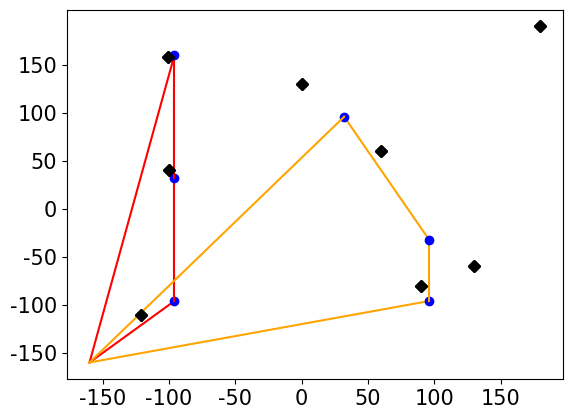

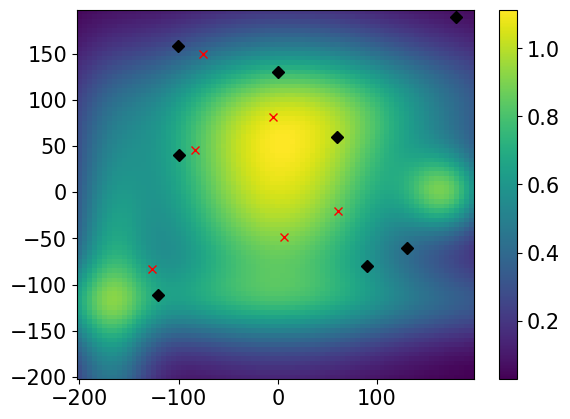

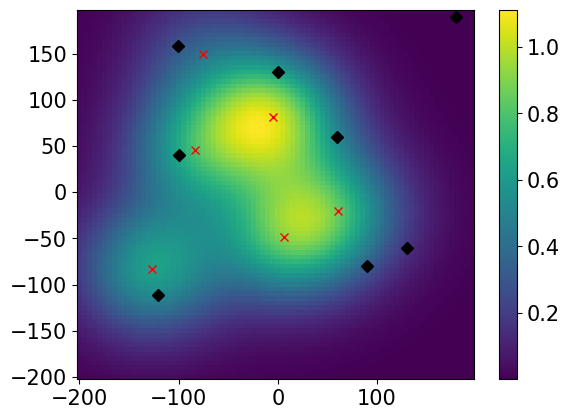

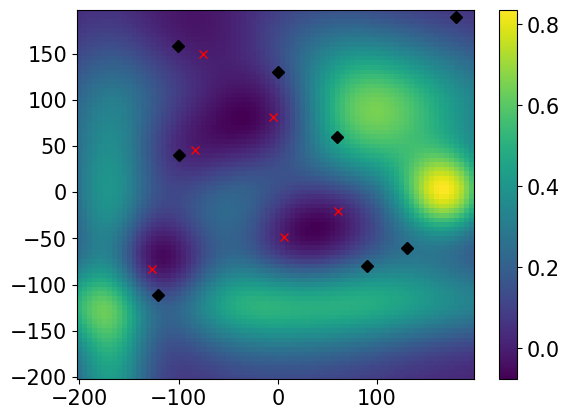

[0.66602917]


In [ ]:
# Do not have wind and 4 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,3, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)



X = np.arange(-200, 200, 5)
D = len(X)
Y = np.arange(-200, 200, 5)
Z = [[x,y] for y in Y for x in X]

Z_compare = np.array([measurement(x,y) for y in Y for x in X])


X, Y = np.meshgrid(X, Y)
K = set()
for item in P:
    for e in item:
      K.add(e)
K = K - set(['V0'])

m, Z, S_pos = Problem.Prediction(K, gpr.kernel_, Z, measurement)

Z = Z.diagonal()
Z = Z.reshape((D,D))
'''
c = plt.pcolormesh(X, Y, Z)
#plt.title("Variance")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")

plt.show()
'''
plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare )
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

m = m.reshape((D,D))
c = plt.pcolormesh(X, Y, m, )
#plt.title("Mean")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare - m)
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

total_error = 0
for i in range(1000):
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/1000)

# Different variance (deterministic)

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math
from time import process_time
from itertools import combinations

# The Class MSD is the main problem and contains all necessary parameters

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


from pandas.io.formats.style_render import non_reducing_slice
class MSD:
  def __init__(self, Wind_model, graph=None, pois=set(), z=0, V_start='a', V_end='a', t_start=0, t_end = 1, norm = 400):
    self.graph = graph
    self.pois = pois
    self.V_start = V_start
    self.V_end = V_end
    self.t_end = t_end
    self.t_start = t_start
    self.norm = 1
    self.z = z

    self.dynamic_model = Wind_model

  def MI_distance(self, S):
    total_reward = 0

    for s in S:
      reward = 0
      (x,y) = self.graph.get_pos(s)
      (x,y,z) = self.dynamic_model.step(self.t_start, self.t_end, x, y, self.z)
      for poi in self.pois:
        reward += self.distance(poi[0], poi[1], x, y)

      total_reward += 1/reward

    return total_reward

  # A function to compute Mutual Information
  def Prediction(self, S, kernel, y, measurement, noise_coviance=400):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = np.array(y)


    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    return mean, variance, S_pos

  def error(self, S, kernel, measurement, noise_coviance=400):

    D = len(self.pois)

    S_pos = []
    measurement_value = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z, (0, noise_coviance**0.5))
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
      measurement_value.append([measurement(pos[0]/self.norm, pos[1]/self.norm)])
    S_pos = np.array(S_pos)
    measurement_value = np.array(measurement_value)


    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm+0.001])
    POI_pos = np.array(POI_pos)


    #variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    #,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    mean = np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , measurement_value)


    error =0

    for i in range(POI_pos.shape[0]):

      pos = POI_pos[i]
      value = measurement(pos[0]/self.norm, pos[1]/self.norm)

      error += (value-mean[i])**2

    return error**0.5

  # A function to compute Mutual Information
  def MI(self, S, kernel):

    D = len(self.pois)

    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul(kernel(POI_pos, S_pos)
    ,np.linalg.inv(kernel(S_pos, S_pos))) , kernel( S_pos, POI_pos))

    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)


  # A function to compute Mutual Information
  def MI_stochastic(self, S, kernel, W=(49.8**2), noise_coviance=400):

    D = len(self.pois)

    # Convert the sensor set to position array
    S_pos = []
    for i in S:
      pos = self.graph.get_pos(i)
      pos = self.dynamic_model.step(self.t_start, self.t_end, pos[0], pos[1], self.z)
      S_pos.append([pos[0]/self.norm, pos[1]/self.norm])
    S_pos = np.array(S_pos)

    # Convert the PoIs set to position array
    POI_pos = []
    for i in self.pois:
      POI_pos.append([i[0]/self.norm, i[1]/self.norm])
    POI_pos = np.array(POI_pos)

    # Appoximation
    Kernel_A = kernel(POI_pos, S_pos)
    Kernel_B = kernel(S_pos, S_pos)

    for i in range(len(POI_pos)):
      for j in range(len(S)):
        x_diff = (POI_pos[i] - S_pos[j])
        dx = self.dynamic_model.W_x(S_pos[j][0], S_pos[j][1], 0)
        dy = self.dynamic_model.W_y(S_pos[j][0], S_pos[j][1], 0)
        dd = (dx*dx + dy*dy)**0.5/4
        numerator  = 1/(W+  noise_coviance * dd)
        determinator = 1+ ( 1/W * noise_coviance *dd)

        Kernel_A[i,j] = np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    for i in range(len(S)):
      for j in range(len(S)):
        if not i == j:
          x_diff = (S_pos[i] - S_pos[j])

          dx = self.dynamic_model.W_x(S_pos[i][0], S_pos[i][1], 0)
          dy = self.dynamic_model.W_y(S_pos[i][0], S_pos[i][1], 0)
          dd = (dx*dx + dy*dy)**0.5/4

          dx2 = self.dynamic_model.W_x(S_pos[j][0], S_pos[j][1], 0)
          dy2 = self.dynamic_model.W_y(S_pos[j][0], S_pos[j][1], 0)
          dd2 = (dx2*dx2 + dy2*dy2)**0.5/4

          numerator  = 1/(W+  (dd+dd2)*noise_coviance)
          determinator = 1+ ( 1/W * (dd+dd2)*noise_coviance)

          Kernel_B[i,j] =  np.exp(-0.5 * np.matmul( x_diff.transpose()* numerator , x_diff))/determinator

    Kernel_C = Kernel_A.transpose()

    variance = kernel(POI_pos, POI_pos) - np.matmul(np.matmul( Kernel_A
    ,np.linalg.inv(Kernel_B)) , Kernel_C)



    log_variance = np.maximum(np.log(np.linalg.det(variance)),-1000000*len(S))

    return -0.5 * (log_variance)

  # Different solvers to solve the main problem
  def planner(self, n_agents, budget, n_sensor, method="D", kernal=50):
    if method == "D":

      return self.SGA(budget, n_sensor, n_agents, kernal)

    if method == "S":
      pass


    path = [("V0",0)]
    return path


  # Computer the cost
  def cost(self, S):
    edge_list = self.TSP_solver(S)

    total_cost = 0
    for edge in edge_list:
      x1,y1 = self.graph.get_pos(edge[0])
      x2,y2 = self.graph.get_pos(edge[1])
      total_cost += self.distance(x1,y1,x2,y2)
    return total_cost

  def TSP_solver(self, S):
    Gp = nx.Graph()
    for i in S:
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    cycle = nx_app.christofides(Gp, weight="weight")
    edge_list = list(nx.utils.pairwise(cycle))

    return edge_list

  def distance(self, x1, y1, x2, y2):
    return sqrt((x1-x2)**2 + (y1-y2)**2)


  def SGA(self, budget, n_sensor, n_agents, kernal = 0):
    A = set()
    P = []
    for i in range(n_agents):
      P.append(self.GCB(A, budget, n_sensor, kernal))
      A.update(P[-1])

    return P

  def GCB(self, A, budget, n_sensor, kernal = 0):
    S = set([self.V_start])
    V_prime = set(self.graph.get_nodes())

    V_prime = V_prime - A
    V_prime = V_prime - S

    while len(V_prime) and n_sensor > 0:
      max_reward = -float('inf')
      max_node = None

      for i in V_prime:
        G = S.copy()
        G.add(i)

        #print(self.MI_stochastic(G, kernal), self.MI(G, kernal))
        reward = self.MI(G, kernal) - self.MI(S, kernal)
        #print(G, self.MI(G, kernal))
        if len(S) == 1:
          cost1 =  self.cost(G) + 500
        else:
          cost1 =  self.cost(G) - self.cost(S) + 500


        if reward/cost1 > max_reward:
          max_reward = reward/cost1
          max_node = i

      G = S.copy()
      G.add(max_node)

      #print(G)
      if  self.cost(G) <= budget:
        S.add(max_node)
        n_sensor -= 1

      V_prime = V_prime - (set([max_node]))
    return S

  def brute_force(self, n_agents, budget, n_sensor, method="D", kernal=0):
    P = []
    max_reward = -float('inf')
    P_prime = [set(self.V_start)]


    for i in range(n_agents):
      temp = []
      for j in P_prime:
        V_prime = set(self.graph.get_nodes()) - j
        for k in [com for com in combinations(V_prime, n_sensor)]:
          k = set(k)
          k.add(self.V_start)
          if self.cost(k) <= budget:
            temp.append(k)
      P_prime = temp

    for j in P_prime:
      reward = self.MI(j, kernal)
      if  reward > max_reward:
        P = j
        max_reward = max_reward

    return P

  def visualize(self, S):
    fig, ax = plt.subplots()
    Gp = nx.Graph()

    for i in G.get_nodes():
      Gp.add_node(i , pos = self.graph.get_pos(i))
    pos = nx.get_node_attributes(Gp, "pos")
    H = Gp.copy()


    # Calculating the distances between the nodes as edge's weight.
    for i in pos.keys():
        for j in pos.keys():
            if not i == j:
              dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
              dist = dist
              Gp.add_edge(i, j, weight=dist)

    colors = [ "red", "orange", "purple", "yellow"]
    for S_S, color in zip(S,colors):
      edge_list = self.TSP_solver(S_S)
      #print(edge_list)

      for edge in edge_list:
        point_a = G.get_pos(edge[0])
        point_b = G.get_pos(edge[1])
        ax.plot([point_a[0],point_b[0]],[point_a[1], point_b[1]], color=color)
        if not edge[1] == self.V_start:
          ax.plot(point_b[0], point_b[1], "*r")
          point_b = self.dynamic_model.step(self.t_start, self.t_end, point_b[0], point_b[1], self.z)
          ax.plot(point_b[0], point_b[1], "bo")

      for PoI in self.pois:
        ax.plot(PoI[0],PoI[1],"kD")
      '''
      # Draw the route
      nx.draw_networkx(
          Gp,
          pos,
          with_labels=True,
          edgelist=edge_list,
          edge_color="red",
          node_size=200,
          width=3,
      )
      '''
    return ax


[{'V7', 'V12', 'V0', 'V8', 'V22'}, {'V21', 'V27', 'V16', 'V0', 'V2'}]


([<matplotlib.axis.YTick at 0x78ea3a805120>,
 [Text(0, -150, '-150'),
  Text(0, -100, '-100'),
  Text(0, -50, '-50'),
  Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

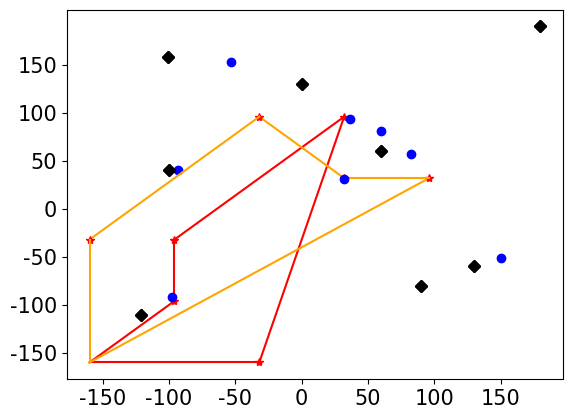

In [ ]:
# Do not have wind and 4 sensor and medium budget
Problem = MSD(model, G, PoIs, z, "V0", "V0", t_start, t_end)

P = Problem.planner(2,8.7e2,4, kernal = gpr.kernel_)
print(P)
fig = Problem.visualize(P)
x_label = np.arange(-150,151,50)
plt.xticks(x_label, x_label)
plt.yticks(x_label, x_label)

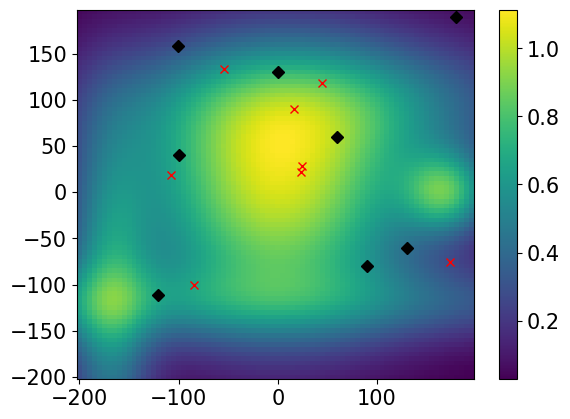

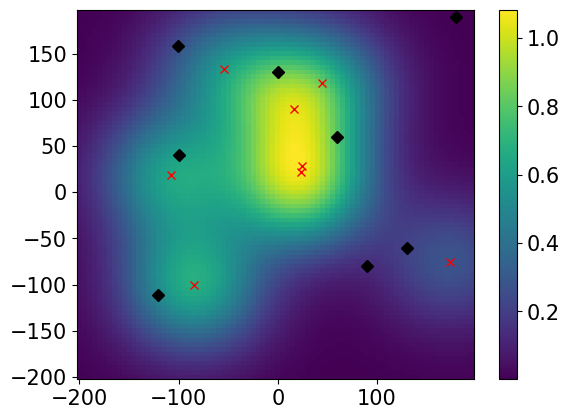

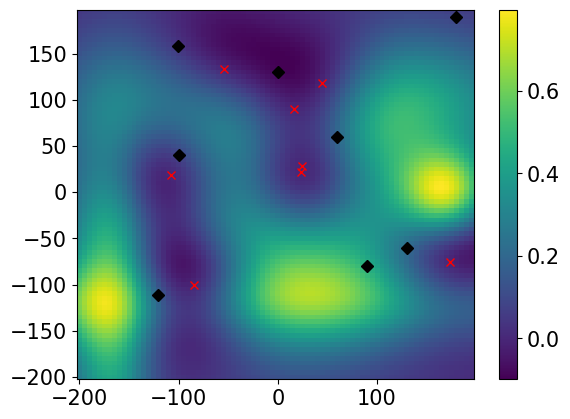

[0.52852034]


In [ ]:
def measurement(x,y):
  return guassian_function(1,x,y,0,0,100,100) + guassian_function(0.6,x,y,170,0,30,30) + guassian_function(0.5,x,y,-170,-120,30,130) + guassian_function(0.3,x,y,-170,-120,630,30) + guassian_function(0.4,x,y,50,100,150,50)



X = np.arange(-200, 200, 5)
D = len(X)
Y = np.arange(-200, 200, 5)
Z = [[x,y] for y in Y for x in X]

Z_compare = np.array([measurement(x,y) for y in Y for x in X])


X, Y = np.meshgrid(X, Y)
K = set()
for item in P:
    for e in item:
      K.add(e)
K = K - set(['V0'])

m, Z, S_pos = Problem.Prediction(K, gpr.kernel_, Z, measurement)

Z = Z.diagonal()
Z = Z.reshape((D,D))
'''
c = plt.pcolormesh(X, Y, Z)
#plt.title("Variance")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")

plt.show()
'''

Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare )
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

m = m.reshape((D,D))
c = plt.pcolormesh(X, Y, m, )
#plt.title("Mean")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()


Z_compare = Z_compare.reshape((D,D))
c = plt.pcolormesh(X, Y, Z_compare - m)
#plt.title("Error")
plt.colorbar(c)

for PoI in Problem.pois:
        plt.plot(PoI[0],PoI[1],"kD")
for pos in S_pos:
      plt.plot(pos[0],pos[1],"rx")

plt.show()

total_error = 0
for i in range(1000):
  total_error +=  Problem.error(K, gpr.kernel_, measurement)
print(total_error/1000)